In [1]:
from typing import List
from datetime import datetime as dt

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%run ./utils.ipynb

## ASMR 2 data

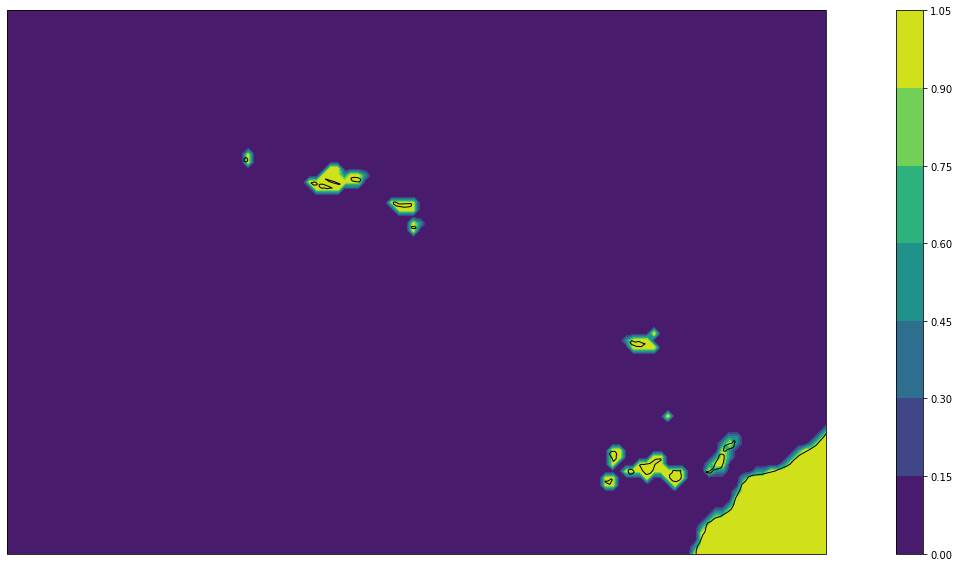

In [80]:
# ASMR2

MIN_LATITUDE, MAX_LATITUDE = 25, 45
MIN_LONGITUDE, MAX_LONGITUDE = 320, 350
PASS = 2

# Load AMSR2 data
raw_data = xr.open_dataset(f"../data/amsr2/RSS_AMSR2_ocean_L3_daily_2020-11-01_v08.2.nc")
data = raw_data.sel({
    "lon": slice(MIN_LONGITUDE, MAX_LONGITUDE), 
    "lat": slice(MIN_LATITUDE, MAX_LATITUDE), 
}).mean("pass")

# Plot data
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.contourf(data["lon"], data["lat"], data["land_mask"] + data["coast_mask"], transform=ccrs.PlateCarree())
plt.colorbar()
# ax.quiver(lon, lat, u, v)
ax.coastlines()
plt.show()

In [238]:
raw_data = xr.open_dataset(f"../data/amsr2/RSS_AMSR2_ocean_L3_daily_2020-11-01_v08.2.nc")
data = raw_data.mean("pass")[["land_mask", "coast_mask"]]
data = data.rename({"lon": "longitude", "lat": "latitude"})
data = data.to_dataframe().reset_index()
data_minus, data_plus = data.copy(), data.copy()
data_minus["longitude"] = (data_minus["longitude"] - 0.125 + 180) % 360 - 180
data_minus["latitude"] = data_minus["latitude"] - 0.125
data_plus["longitude"] = (data_plus["longitude"] + 0.125 + 180) % 360 - 180
data_plus["latitude"] = data_plus["latitude"] + 0.125
data = data_minus.merge(data_plus, how="outer", on=["longitude", "latitude"])
data["land_mask"] = np.minimum(1, data[["land_mask_x", "land_mask_y"]].sum(axis=1))
data["coast_mask"] = np.minimum(1, data[["coast_mask_x", "coast_mask_y"]].sum(axis=1))
data = data[["latitude", "longitude", "land_mask", "coast_mask"]].set_index(["latitude", "longitude"]).to_xarray()
data.to_netcdf(f"../data/other/land_coast_mask.nc")


In [164]:
363 % 360

3

In [76]:
# GFS
data = xr.open_dataset(f"../data/gfs.t00z.sfcanl.nc")
# data

In [77]:
MIN_LATITUDE, MAX_LATITUDE = 25, 45
MIN_LONGITUDE, MAX_LONGITUDE = 320, 350

data = xr.open_dataset("https://thredds.ucar.edu/thredds/dodsC/casestudies/python-gallery/NAM_20161031_1200.nc")
# data.sel(lon=slice(MIN_LONGITUDE, MAX_LONGITUDE), lat=slice(MIN_LATITUDE, MAX_LATITUDE))
data_500 = data.sel(isobaric=500).drop(["x", "y"]).assign_coords({"lat": data.lat, "lon": data.lon}).mean("time")
data_500

<xarray.Dataset>
Dimensions:                                    (height_above_ground1: 2, height_above_ground: 1, height_above_ground3: 2, y: 428, x: 614)
Coordinates:
    isobaric                                   float32 500.0
  * height_above_ground1                       (height_above_ground1) float32 ...
  * height_above_ground                        (height_above_ground) float32 2.0
  * height_above_ground3                       (height_above_ground3) float32 ...
    lat                                        (y, x) float64 ...
    lon                                        (y, x) float64 ...
  * y                                          (y) float32 -832.2 ... 4.373e+03
  * x                                          (x) float32 -4.224e+03 ... 3.2...
Data variables:
    LambertConformal_Projection                float64 0.0
    Temperature_isobaric                       (y, x) float32 267.8 ... 250.6
    Temperature_height_above_ground            (height_above_ground1, y, x) float32 ...
    Relative_humidity_isobaric                 (y, x) float32 16.0 18.0 ... 31.0
    Dew_point_temperature_height_above_ground  (height_above_ground, y, x) float32 ...
    u-component_of_wind_isobaric               (y, x) float32 -2.616 ... -17.99
    v-component_of_wind_height_above_ground    (height_above_ground3, y, x) float32 ...
    u-component_of_wind_height_above_ground    (height_above_ground3, y, x) float32 ...
    Geopotential_height_isobaric               (y, x) float32 5.868e+03 ... 5...
    v-component_of_wind_isobaric               (y, x) float32 1.637 ... 8.262

In [102]:
from scipy.ndimage import gaussian_filter

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
# uwnd_500 = gaussian_filter(data_500['u-component_of_wind_isobaric'].data[0], sigma=3.0)
# vwnd_500 = gaussian_filter(data_500['v-component_of_wind_isobaric'].data[0], sigma=3.0)
uwnd_500 = data_500['u-component_of_wind_isobaric'].values
vwnd_500 = data_500['v-component_of_wind_isobaric'].values

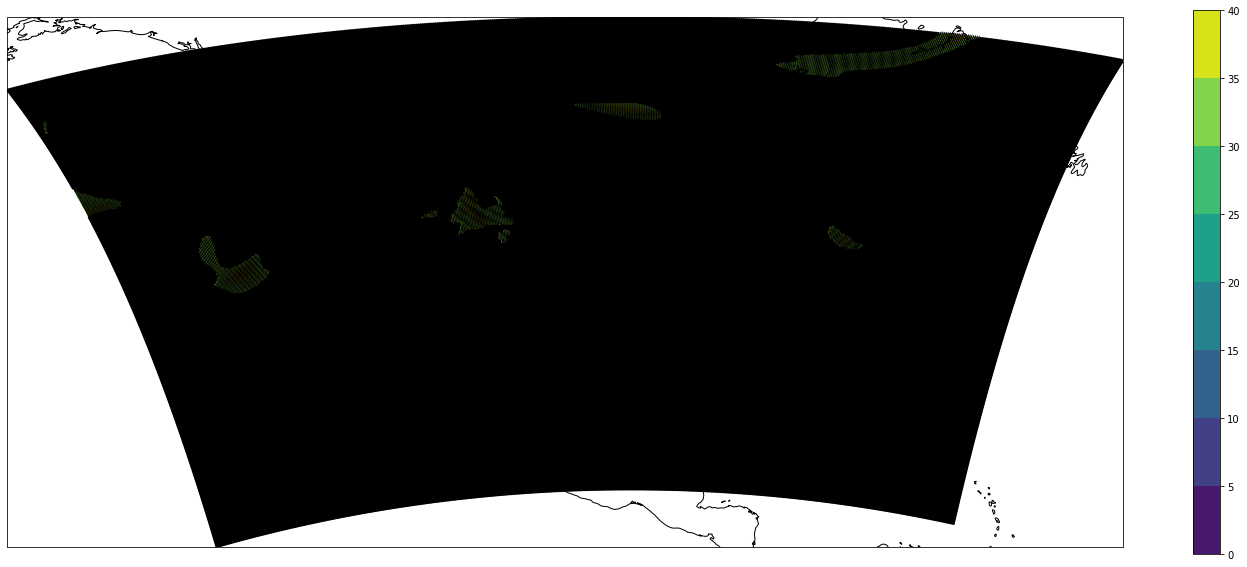

In [105]:
ws_speed_500 = np.sqrt(uwnd_500**2 + vwnd_500**2)

# Plot data
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.contourf(data["lon"], data["lat"], ws_speed_500, transform=ccrs.PlateCarree())
plt.colorbar()
ax.quiver(data["lon"], data["lat"], uwnd_500, vwnd_500)
ax.coastlines()
plt.show()

## ECMWF

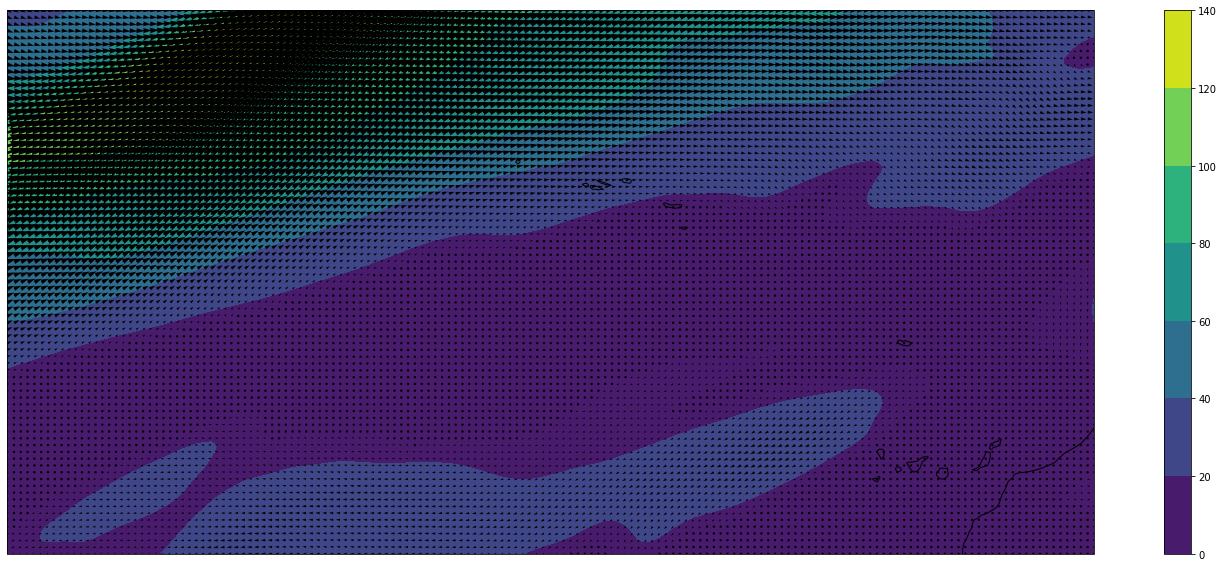

In [64]:
MIN_LATITUDE, MAX_LATITUDE = 25, 45
MIN_LONGITUDE, MAX_LONGITUDE = -50, -10
PRESSURE = 500

filepath = "../data/ecmwf/ecmwf-202011-500_1000Hpa.grib"
ds = xr.open_dataset(filepath, engine='cfgrib')
ds = ds.rename({
    "d": "divergence",
    "cc": "cloud_cover",
    "pv": "potential_vorticity",
    "r": "relative_humidity",
    "t": "temperature",
    "u": "u_wind",
    "v": "v_wind",
    "w": "vertical_velocity",
    "vo": "vorticity",
}).sortby(["time", "latitude", "longitude"])

ds = ds.sel(
    isobaricInhPa=slice(PRESSURE, PRESSURE), 
    time=slice("2020-11-01T00:00:00", "2020-11-01T00:00:00"),
    longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
    latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
).mean("time").mean("isobaricInhPa")

# Data
wind_speed = np.sqrt(ds.u_wind**2 + ds.v_wind**2) * 3600 / 1852

# Plot data
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.contourf(ds["longitude"], ds["latitude"], wind_speed, transform=ccrs.PlateCarree())
plt.colorbar()
ax.quiver(ds["longitude"], ds["latitude"], ds.u_wind, ds.v_wind)
ax.coastlines()
plt.show()

skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1604188800, 1604210400, 1604232000, 1604253600, 1604275200,
       1604296800, 1604318400, 1604340000, 1604361600, 1604383200,
       1604404800, 1604426400, 1604448000, 1604469600, 1604491200,
       1604512800, 1604534400, 1604556000, 1604577600, 1604599200,
       1604620800, 1604642400, 1604664000, 1604685600, 1604707200,
       1604728800, 1604750400, 1604772000, 1604793600, 1604815200,
       1604836800, 160485840

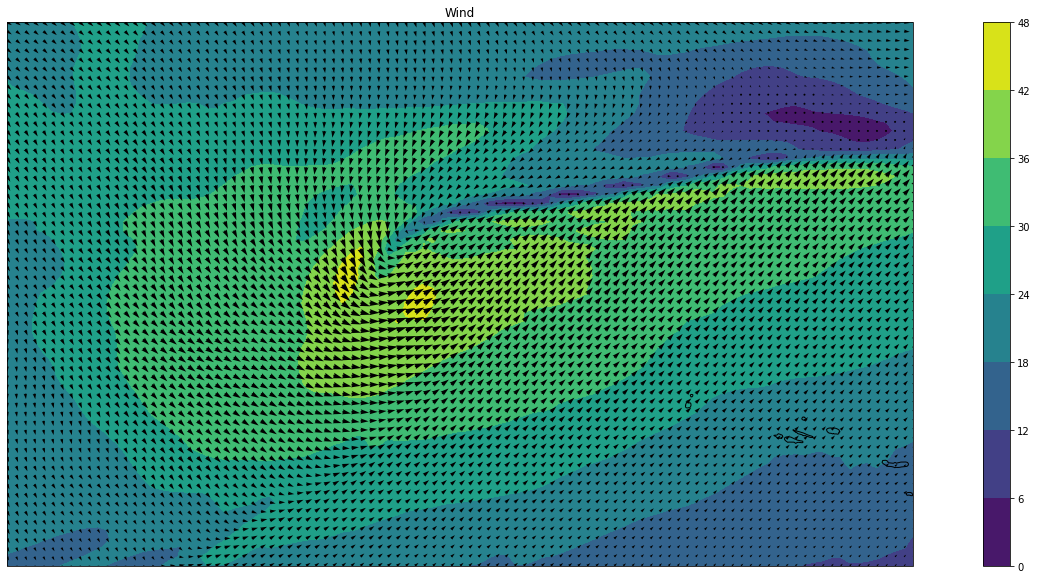

In [74]:
MIN_LATITUDE, MAX_LATITUDE = 35, 50
MIN_LONGITUDE, MAX_LONGITUDE = -50, -25

filepath = "../data/ecmwf/ecmwf-202011-surface.grib"
ds = xr.open_dataset(filepath, engine='cfgrib')
ds = ds.rename({
    "u10": "u_wind",
    "v10": "v_wind",
    "t2m": "temperature",
    "sp": "pressure",
    "tcc": "cloud_cover",
}).sortby(["time", "latitude", "longitude"])

ds = ds.sel(
    time=slice("2020-11-01T00:00:00", "2020-11-01T00:00:00"),
    longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
    latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
).mean("time")

# Data
wind_speed = np.sqrt(ds.u_wind**2 + ds.v_wind**2) * 3600 / 1852

# Plot data
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.contourf(ds["longitude"], ds["latitude"], wind_speed, transform=ccrs.PlateCarree())
plt.colorbar()
ax.quiver(ds["longitude"], ds["latitude"], ds.u_wind, ds.v_wind)
ax.coastlines()
plt.title("Wind")
plt.show()

In [239]:
from datetime import datetime as dt

import re
import xarray as xr
import pathlib as pl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [249]:
# Temporal filters
YEAR_MONTH = "202011"
MIN_TIMESTAMP = "2020-11-01T00:00:00"
MAX_TIMESTAMP = "2020-11-30T18:00:00"

# Spatial filters
MIN_LATITUDE, MAX_LATITUDE = 20, 40
MIN_LONGITUDE, MAX_LONGITUDE = -40, -10

# Parameters
DATA_DIR = pl.Path.cwd().resolve().parent / "data"

In [250]:
# Processed parameters
ECMWF_SURFACE_DATA_FILEPATH = DATA_DIR / "ecmwf" / f"ecmwf-{YEAR_MONTH}-surface.grib"
ECMWF_500HPA_DATA_FILEPATH = DATA_DIR / "ecmwf" / f"ecmwf-{YEAR_MONTH}-500_1000Hpa.grib"
LAND_DATA_FILEPATH = DATA_DIR / "other" / "land_coast_mask.nc"

In [278]:
def convert_ms_to_knot(velocity_in_ms: np.ndarray) -> np.ndarray:
    return velocity_in_ms * 3600 / 1852

def load_and_filter_data():
    # Load ECMWF surface data
    ecmwf_data = xr.open_dataset(ECMWF_SURFACE_DATA_FILEPATH, engine='cfgrib')
    ecmwf_data = ecmwf_data.rename({
        "u10": "u_wind",
        "v10": "v_wind",
        "t2m": "temperature",
        "sp": "pressure",
        "tcc": "cloud_cover",
    }).sortby(["time", "latitude", "longitude"])
    ecmwf_data = ecmwf_data.sel(
        longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
        latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
        time=slice(MIN_TIMESTAMP, MAX_TIMESTAMP)
    )
    
    # Load ECMWF 500 Hpa data
    ecmwf_500_data = xr.open_dataset(ECMWF_500HPA_DATA_FILEPATH, engine='cfgrib')
    ecmwf_500_data = (
        ecmwf_500_data
        .rename({
            "u": "u_wind500",
            "v": "v_wind500",
            "t": "temperature500",
            "d": "divergence500",
            "w": "vertical_velocity"
        })
        .sortby(["time", "longitude", "latitude"])
        .sel(
            isobaricInhPa=slice(500, 500),
            longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
            latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
        )
        .mean(["isobaricInhPa"])
        [["u_wind500", "v_wind500", "temperature500", "divergence500", "vertical_velocity"]]
    )
    
    # Load land & coast data
    land_coast_data = xr.open_dataset(LAND_DATA_FILEPATH)
    land_coast_data = land_coast_data.sel(
        longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
        latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
    )
    # Merge
    data = xr.merge([ecmwf_data, ecmwf_500_data, land_coast_data]).sortby("time")
    return data

# Load ECMWF data
data = load_and_filter_data()
data = data.assign(wind_speed=lambda x: convert_ms_to_knot(np.sqrt(x.u_wind**2 + x.v_wind**2)))
data["pressure"] = data["pressure"] / 100

Ignoring index file '/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/data/ecmwf/ecmwf-202011-surface.grib.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1604188800, 1604210400, 1604232000, 1604253600, 1604275200,
       1604296800, 1604318400, 1604340000, 1604361600, 1604383200,
       1604404800, 1604426400, 1604448000, 1604469600, 1604491200,
       1604512800, 1604534400, 1604556000, 1604577600, 1604599200,
       1604

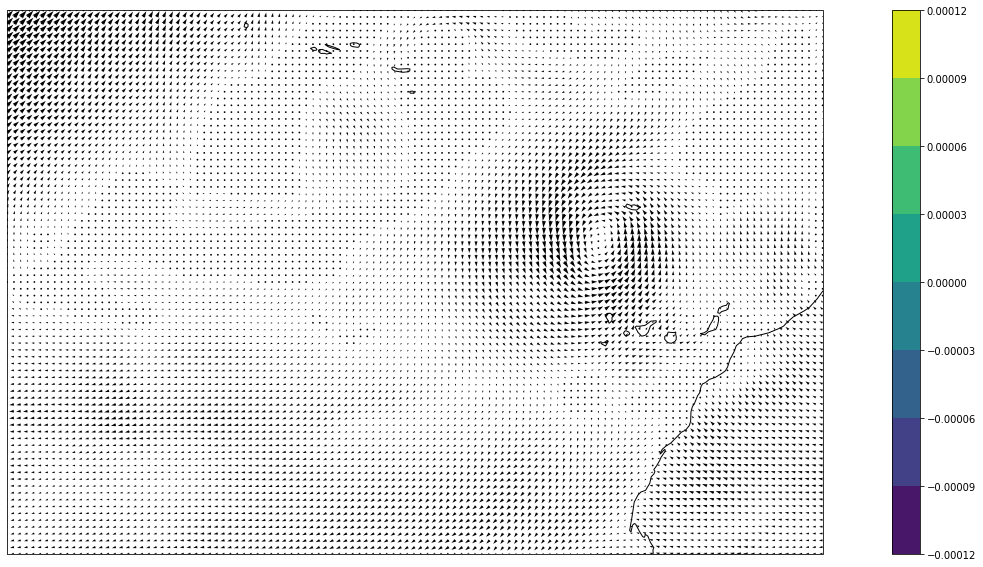

In [295]:
DATE = "2020-11-15"
HOUR = "12"
TIMESTAMP = f"{DATE}T{HOUR}:00:00"
tmp_data = data.sel(time=slice(TIMESTAMP, TIMESTAMP)).mean("time")


fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
plt.contourf(tmp_data["longitude"], tmp_data["latitude"], tmp_data["divergence500"], transform=ccrs.PlateCarree())
# plt.pcolormesh(tmp_data["longitude"], tmp_data["latitude"], tmp_data["vertical_velocity"], shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
ax.quiver(tmp_data["longitude"], tmp_data["latitude"], tmp_data["u_wind"], tmp_data["v_wind"])
ax.coastlines()
plt.colorbar()
plt.show()


In [276]:
    # Load ECMWF 500 Hpa data
    ecmwf_500_data = xr.open_dataset(ECMWF_500HPA_DATA_FILEPATH, engine='cfgrib')
    ecmwf_500_data = (
        ecmwf_500_data
        .rename({
            "u": "u_wind500",
            "v": "v_wind500",
            "t": "temperature500",
            "d": "divergence500",
            "w": "vertical_velocity"
        })
        .sortby(["time", "longitude", "latitude"])
        .sel(
            isobaricInhPa=slice(500, 500),
            longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
            latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
        )
        .mean(["isobaricInhPa"])
        [["u_wind500", "v_wind500", "temperature500", "divergence500", "vertical_velocity"]]
    )

Ignoring index file '/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/data/ecmwf/ecmwf-202011-500_1000Hpa.grib.923a8.idx' incompatible with GRIB file


In [281]:
tmp_data

<xarray.Dataset>
Dimensions:            (latitude: 161, longitude: 121)
Coordinates:
  * latitude           (latitude) float64 20.0 20.12 20.25 ... 39.75 39.88 40.0
  * longitude          (longitude) float64 -40.0 -39.75 -39.5 ... -10.25 -10.0
    number             int64 0
    step               timedelta64[ns] 00:00:00
    surface            float64 ...
Data variables: (12/13)
    u_wind             (latitude, longitude) float32 -6.243 -6.156 ... 3.976
    v_wind             (latitude, longitude) float32 -1.454 -1.418 ... 2.017
    temperature        (latitude, longitude) float32 298.0 297.9 ... 291.3 291.0
    pressure           (latitude, longitude) float32 1.019e+03 ... 1.02e+03
    cloud_cover        (latitude, longitude) float32 0.6245 0.5933 ... 1.0 1.0
    u_wind500          (latitude, longitude) float32 6.159 6.255 ... 14.48 14.69
    ...                 ...
    temperature500     (latitude, longitude) float32 266.8 266.8 ... 261.8 261.7
    divergence500      (latitude, longitude) float32 1.781e-05 ... 2.541e-05
    vertical_velocity  (latitude, longitude) float32 0.07387 0.05678 ... -0.1268
    land_mask          (latitude, longitude) float64 nan nan nan ... nan nan nan
    coast_mask         (latitude, longitude) float64 nan nan nan ... nan nan nan
    wind_speed         (latitude, longitude) float32 12.46 12.28 ... 8.502 8.667